<a href="https://colab.research.google.com/github/JaradAng/tensorflow_training/blob/main/transfer_learning_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#bringing in the helper functions to save time
!wget https://raw.githubusercontent.com/JaradAng/tensorflow_training/main/helper_functions.py

--2022-12-20 14:29:09--  https://raw.githubusercontent.com/JaradAng/tensorflow_training/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10234 (10.0K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   9.99K  --.-KB/s    in 0s      

2022-12-20 14:29:09 (82.4 MB/s) - ‘helper_functions.py’ saved [10234/10234]



In [2]:
#importing them to notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [3]:
# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

unzip_data('101_food_classes_10_percent.zip')

train_dir = '101_food_classes_10_percent/train'

test_dir = '101_food_classes_10_percent/test'

--2022-12-20 14:29:14--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.112.128, 74.125.124.128, 172.217.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.112.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   189MB/s    in 9.8s    

2022-12-20 14:29:24 (158 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [4]:
!nvidia-smi

Tue Dec 20 14:29:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    26W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
#walking through directories
walk_through_dir('101_food_classes_10_percent')

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/creme_brulee'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/macaroni_and_cheese'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/miso_soup'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/greek_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/baby_back_ribs'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/french_onion_soup'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/bread_pudding'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pad_thai'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/spaghetti_bolognese'.
There are 0 direct

In [6]:
import tensorflow as tf
#setting up data inputs
IMG_SIZE = (224,224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode = 'categorical',
                                                                                image_size = IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = 'categorical',
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


from tensorflow.python.ops.variables import model_variables
#building model from transfer learning for 10 percent of 101 food classes
1. create modelcheckpoint callbacl
2. create data augmentation layer
3. build headless (no top layer) functional eff.net b0 backbone model and create output layer
4. compile the model_variables
5. feature extract for 5 full epochs and validate of 15% of test data to speed it up

In [7]:
#create checkpoint callback
checkpoint_path = '101_classes_10_percent_data_model_checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only = True,
                                                         monitor = 'val_accuracy',
                                                         save_best_only = True)

In [8]:
#create data augmentation layer to incorporate
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

#set up data aug
data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2)
    #preprocessing.Rescaling(1/255.) Not needing with eff net but if use resnet it is needed
])

In [9]:
#setting up base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

 #set up model architecture
inputs = layers.Input(shape=(224,224,3), name = 'input_layer')
x=data_augmentation(inputs) #augments the images
x = base_model(x, training=False) #puts base model in inference mode
x = layers.GlobalAveragePooling2D(name='global_pool_layer')(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation = 'softmax', name = 'output_layer')(x)
model = tf.keras.Model(inputs, outputs)





16705208/16705208 [==============================] - 0s 0us/step


In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_pool_layer (GlobalAv  (None, 1280)             0         
 eragePooling2D)                                                 
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_____________________________________________

In [11]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'Adam',
              metrics = ['accuracy'])

In [12]:
history_0 = model.fit(train_data_all_10_percent,
                      epochs = 5,
                      steps_per_epoch = len(train_data_all_10_percent),
                      validation_data = test_data,
                      validation_steps= int(0.15 * len(test_data)),
                      callbacks = [checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 95s 339ms/step - loss: 3.3751 - accuracy: 0.2783 - val_loss: 2.5372 - val_accuracy: 0.4364
Epoch 2/5
237/237 [==============================] - 67s 280ms/step - loss: 2.2060 - accuracy: 0.4973 - val_loss: 2.0864 - val_accuracy: 0.4913
Epoch 3/5
237/237 [==============================] - 60s 250ms/step - loss: 1.8124 - accuracy: 0.5717 - val_loss: 1.9001 - val_accuracy: 0.5246
Epoch 4/5
237/237 [==============================] - 57s 238ms/step - loss: 1.5996 - accuracy: 0.6152 - val_loss: 1.8273 - val_accuracy: 0.5283
Epoch 5/5
237/237 [==============================] - 55s 228ms/step - loss: 1.4549 - accuracy: 0.6457 - val_loss: 1.7836 - val_accuracy: 0.5373


In [13]:
feature_extraction_results = model.evaluate(test_data)

790/790 [==============================] - 63s 80ms/step - loss: 1.5821 - accuracy: 0.5859


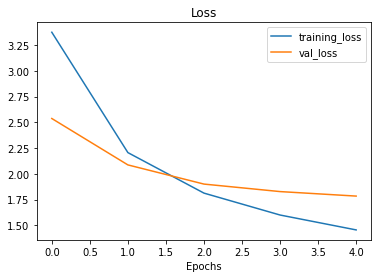

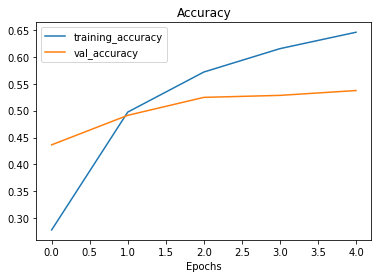

In [14]:
plot_loss_curves(history_0)

In [15]:
# the above model looks to be overfitting when the val loss goes above the training loss

### Fine tune a few layers

In [16]:
#unfreeze the layers in base model
base_model.trainable = True

#refreeze all but last five
for layer in base_model.layers[:-5]:
  layer.trainable = False 

In [17]:
#recompile after fine tuning
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy'])

In [18]:
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name,layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 tf.math.truediv False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [19]:
#fine tuning the model
fine_tune_epochs = 10 #total number of epochs after original 5 

history_0_fine_tuned = model.fit(train_data_all_10_percent,
                                 epochs = fine_tune_epochs,
                                 validation_data = test_data,
                                 validation_steps = (0.15 * len(test_data)),
                                 initial_epoch = history_0.epoch[-1])

Epoch 5/10
237/237 [==============================] - 62s 229ms/step - loss: 1.4826 - accuracy: 0.6007 - val_loss: 1.6346 - val_accuracy: 0.5701
Epoch 6/10
237/237 [==============================] - 52s 219ms/step - loss: 1.0722 - accuracy: 0.7068 - val_loss: 1.6856 - val_accuracy: 0.5533
Epoch 7/10
237/237 [==============================] - 52s 216ms/step - loss: 0.8279 - accuracy: 0.7629 - val_loss: 1.7499 - val_accuracy: 0.5533
Epoch 8/10
237/237 [==============================] - 47s 198ms/step - loss: 0.6632 - accuracy: 0.8111 - val_loss: 1.8141 - val_accuracy: 0.5478
Epoch 9/10
237/237 [==============================] - 46s 193ms/step - loss: 0.5112 - accuracy: 0.8507 - val_loss: 1.9099 - val_accuracy: 0.5433
Epoch 10/10
237/237 [==============================] - 46s 193ms/step - loss: 0.4315 - accuracy: 0.8745 - val_loss: 2.0711 - val_accuracy: 0.5186


In [20]:
#evaluate on all test data
fine_tuned_model_0 = model.evaluate(test_data)

790/790 [==============================] - 62s 78ms/step - loss: 1.8626 - accuracy: 0.5703


In [21]:
#compare the histories
# compare_histories(original_history = history_0,
#                  mew_history = history_0_fine_tuned,
#                  initial_epochs = 5)

### Saving and loading the model

In [22]:
#save the fine tuned model
model.save('/content/drive/MyDrive/101_food_class_model')

In [23]:
#load and evaluate
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/101_food_class_model')

In [24]:
#evaluate loaded model
loaded_model.evaluate(test_data)

790/790 [==============================] - 64s 79ms/step - loss: 1.8626 - accuracy: 0.5703


[1.8626234531402588, 0.5702970027923584]

### Making predictions with our trained model

In [25]:
#make preds with model
pred_probs = loaded_model.predict(test_data, verbose = 1) #set verbose to 1 to see how long is left

790/790 [==============================] - 69s 85ms/step


In [26]:
# how many predictions
len(pred_probs)

25250

In [27]:
#whats the shape of predictions
pred_probs.shape

(25250, 101)

In [29]:
#we get one pred prob per class
print(f'the number of pred probs for sample 0: {len(pred_probs[0])}')
print(f'what pred prob sample 0 looks like: {pred_probs[0]}')
print(f'class with highest pred prob by the model for sample 0: {pred_probs[0].argmax()}')

the number of pred probs for sample 0: 101
what pred prob sample 0 looks like: [9.10249114e-01 7.96501865e-07 1.63747352e-02 2.16850204e-09
 8.59055216e-10 2.18264362e-09 3.79740861e-08 2.76293854e-09
 4.96165048e-05 5.31100966e-07 3.56012322e-08 8.39790246e-08
 2.17504635e-06 2.77689868e-11 1.63286370e-06 5.84999434e-05
 7.40958905e-10 3.46292779e-07 1.44656460e-05 1.42238662e-07
 1.20842924e-06 4.98123285e-08 3.52149527e-07 2.98997122e-07
 7.31960317e-05 1.76479170e-05 1.50046404e-07 1.28641045e-06
 1.00091966e-04 4.96765836e-07 2.62815014e-09 9.90836725e-06
 4.15932732e-07 7.49861499e-07 4.64405857e-05 1.71019696e-08
 5.60419721e-07 5.05528715e-06 1.18339944e-04 1.35584662e-06
 4.58266004e-06 2.70935143e-05 1.71585034e-05 5.87884719e-09
 6.41191150e-07 3.00831658e-07 9.42031238e-06 3.06118011e-07
 3.78110165e-09 2.05698612e-04 1.28432106e-07 1.03321920e-08
 3.86568829e-02 1.71864594e-05 2.40938700e-08 6.35860215e-06
 2.39121451e-04 6.62552557e-05 4.54068882e-04 2.39742735e-06
 2.485

In [30]:
#get the pred classes of each label
pred_classes = pred_probs.argmax(axis=1)

#How do they look?
pred_classes[:10]

array([  0,   0,   0,  38,   0,   9, 100,  46,   0,   0])

In [31]:
#how many pred classes is there
len(pred_classes)

25250

In [33]:
#to get test labels we need to unravel test data batchdataset
y_labels = []

for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) #using argmax because one hot encoded
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [34]:
#how many y labels
len(y_labels)

25250

#evaluating models preds

one way to make sure the models preds are in the same order as test lables is to find the accuracy score

In [35]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true = y_labels,
                                  y_pred = pred_classes)

sklearn_accuracy

0.5702970297029702

### create a confusion matrix

In [38]:
#get list of class names
class_names = test_data.class_names

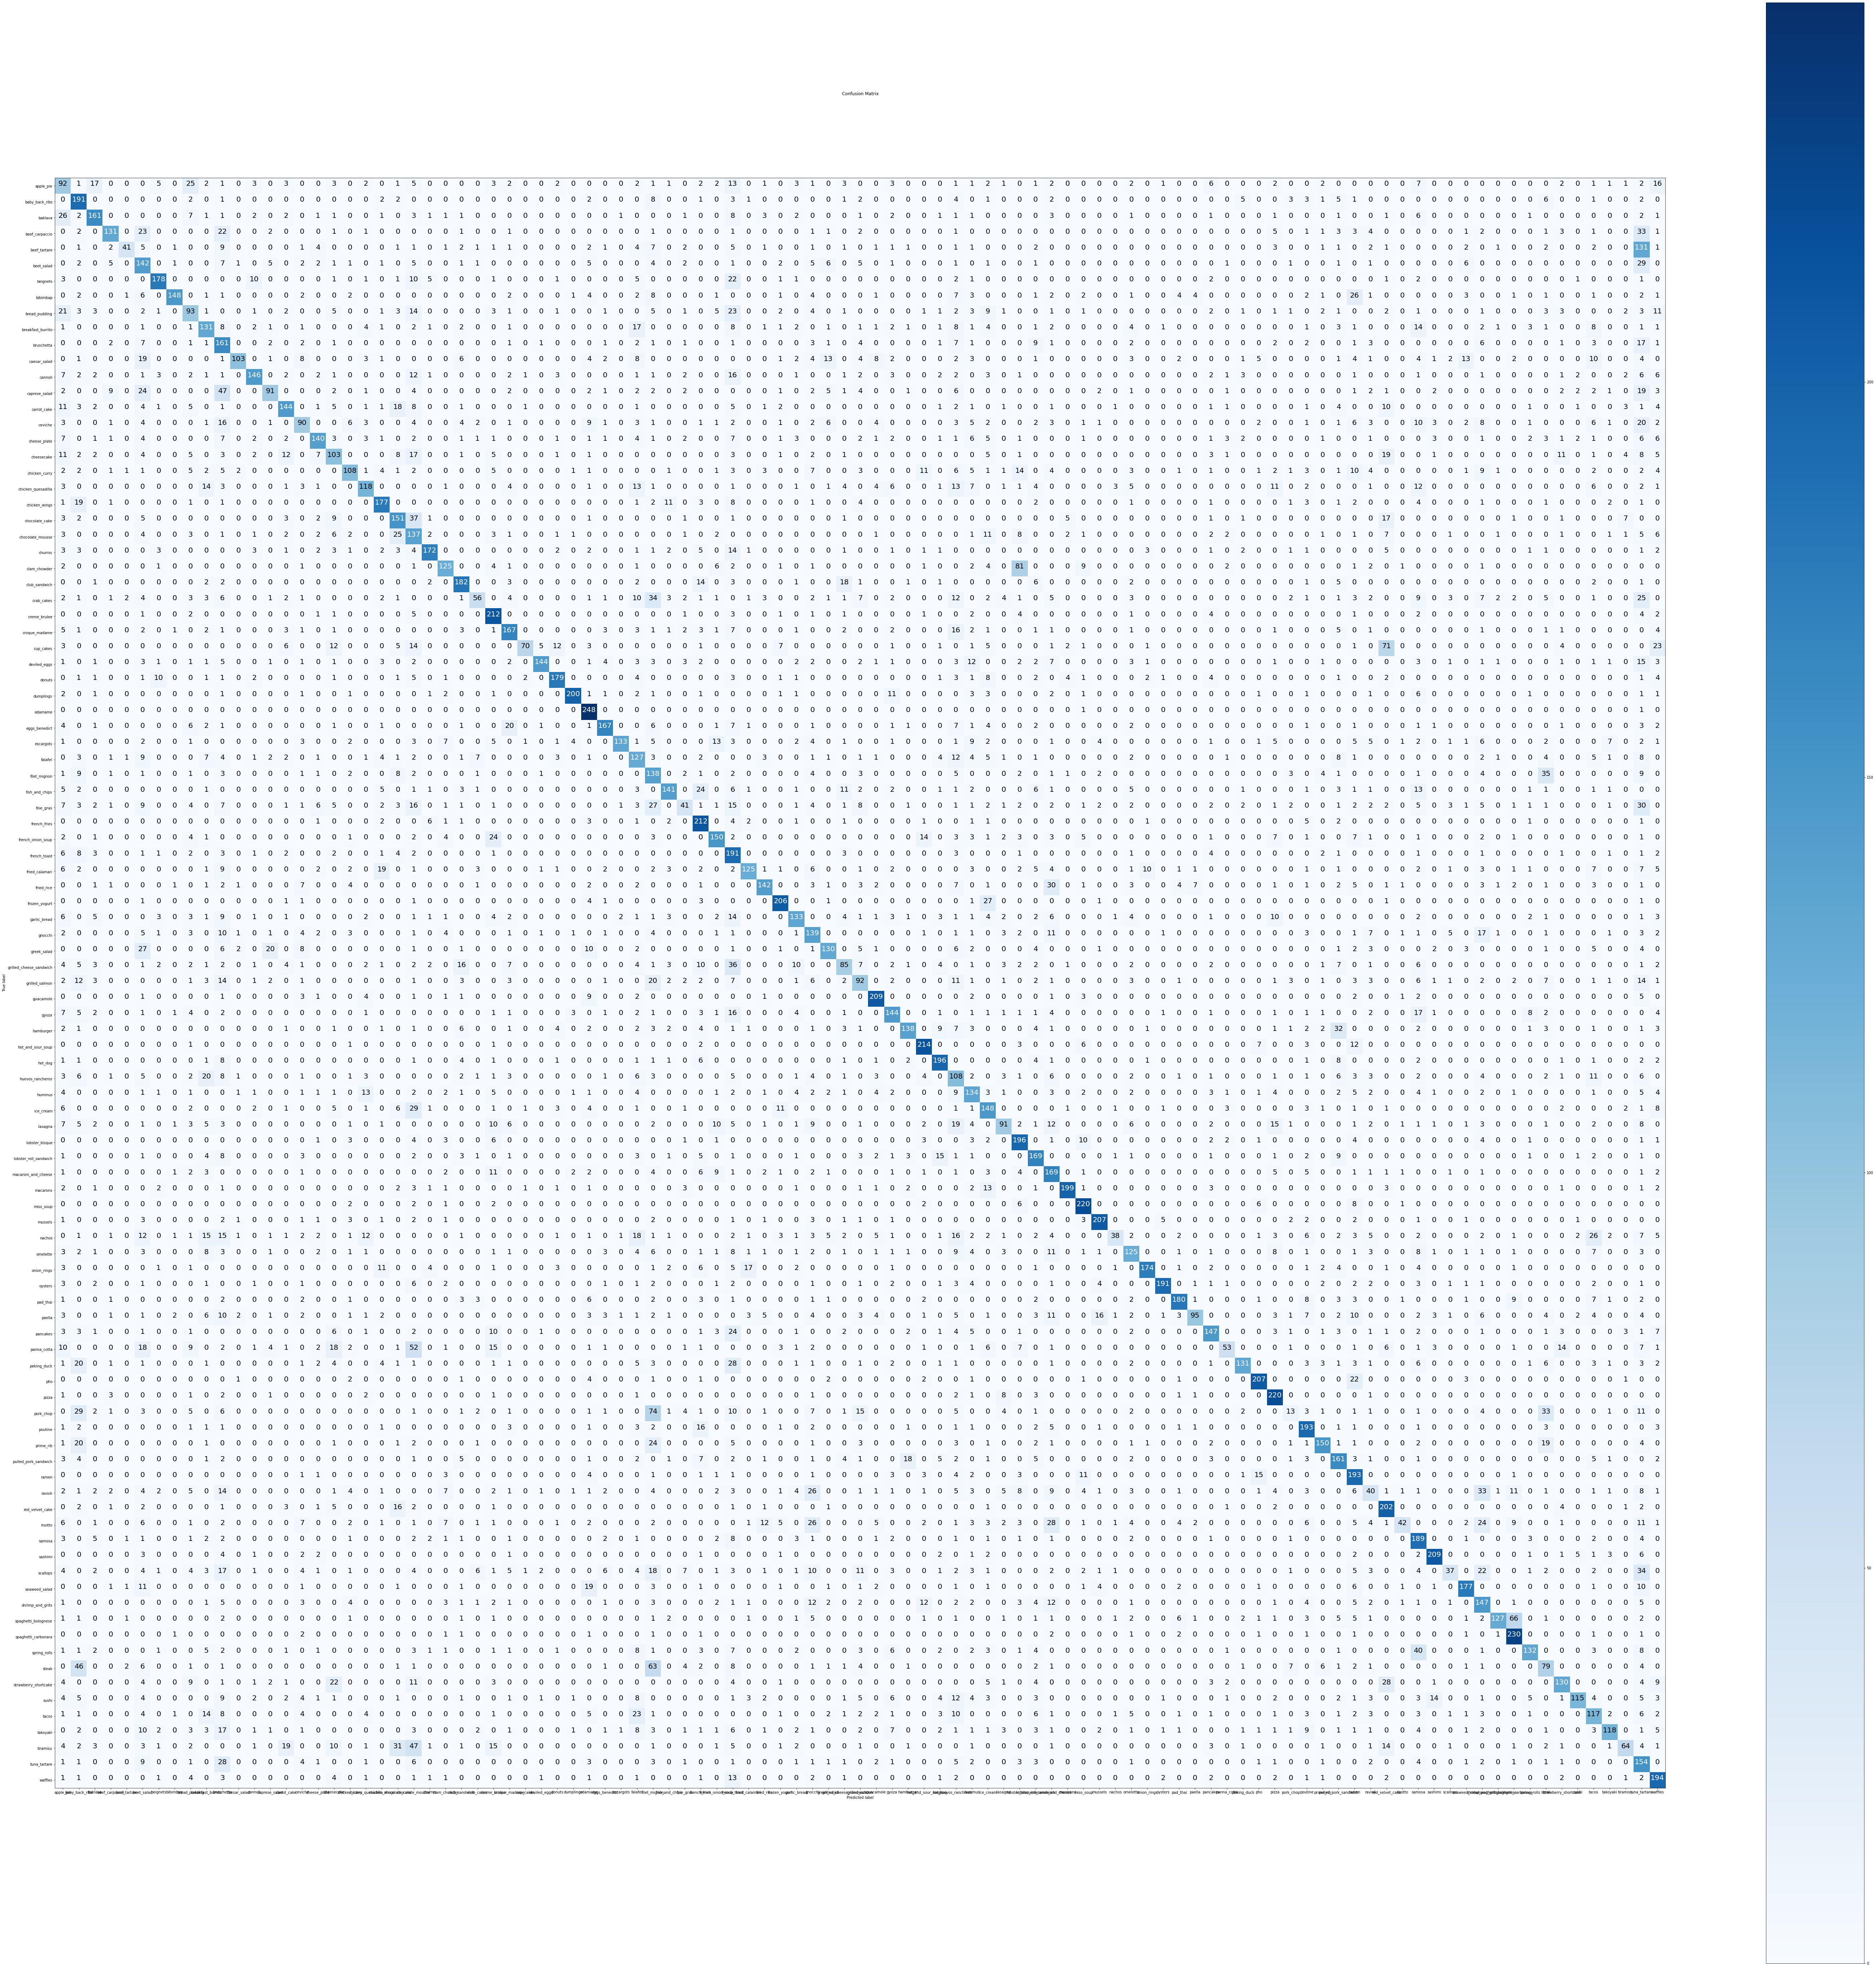

In [40]:
#import helper function
from helper_functions import make_confusion_matrix
make_confusion_matrix(y_true=y_labels,
                      y_pred = pred_classes,
                      classes = class_names,
                      figsize = (100,100),
                      text_size = 20)

### Make a classification report

sk learn has helpful function to acruire classification metric per class, precision, recall, f1 in classification report

In [42]:
#import classification report
from sklearn.metrics import classification_report

print(classification_report(y_true=y_labels, 
                            y_pred = pred_classes))

              precision    recall  f1-score   support

           0       0.25      0.37      0.30       250
           1       0.43      0.76      0.55       250
           2       0.68      0.64      0.66       250
           3       0.77      0.52      0.62       250
           4       0.80      0.16      0.27       250
           5       0.32      0.57      0.41       250
           6       0.80      0.71      0.75       250
           7       0.93      0.59      0.72       250
           8       0.38      0.37      0.37       250
           9       0.47      0.52      0.50       250
          10       0.28      0.64      0.39       250
          11       0.88      0.41      0.56       250
          12       0.76      0.58      0.66       250
          13       0.65      0.36      0.47       250
          14       0.64      0.58      0.61       250
          15       0.47      0.36      0.41       250
          16       0.71      0.56      0.62       250
          17       0.42    

In [44]:
 #get dictionary of classifcation report
 class_report_dict = classification_report(y_labels,
                                           pred_classes,
                                           output_dict=True)

In [45]:
class_report_dict

{'0': {'precision': 0.2548476454293629,
  'recall': 0.368,
  'f1-score': 0.3011456628477905,
  'support': 250},
 '1': {'precision': 0.4272930648769575,
  'recall': 0.764,
  'f1-score': 0.5480631276901003,
  'support': 250},
 '2': {'precision': 0.679324894514768,
  'recall': 0.644,
  'f1-score': 0.6611909650924025,
  'support': 250},
 '3': {'precision': 0.7660818713450293,
  'recall': 0.524,
  'f1-score': 0.6223277909738718,
  'support': 250},
 '4': {'precision': 0.803921568627451,
  'recall': 0.164,
  'f1-score': 0.27242524916943517,
  'support': 250},
 '5': {'precision': 0.31767337807606266,
  'recall': 0.568,
  'f1-score': 0.40746054519368724,
  'support': 250},
 '6': {'precision': 0.8018018018018018,
  'recall': 0.712,
  'f1-score': 0.7542372881355933,
  'support': 250},
 '7': {'precision': 0.925,
  'recall': 0.592,
  'f1-score': 0.7219512195121951,
  'support': 250},
 '8': {'precision': 0.375,
  'recall': 0.372,
  'f1-score': 0.3734939759036145,
  'support': 250},
 '9': {'precision

In [46]:
class_names[70]

'pad_thai'

#Plot all classes f1 scores

In [47]:
#create empty dict
class_f1_score = {}

#loop thru classificaiont report items
for k, v in class_report_dict.items():
  if k  == 'accuracy': # stop once we get to accuracy key
    break
  else:
    class_f1_score[class_names[int(k)]] = v['f1-score']


In [48]:
class_f1_score

{'apple_pie': 0.3011456628477905,
 'baby_back_ribs': 0.5480631276901003,
 'baklava': 0.6611909650924025,
 'beef_carpaccio': 0.6223277909738718,
 'beef_tartare': 0.27242524916943517,
 'beet_salad': 0.40746054519368724,
 'beignets': 0.7542372881355933,
 'bibimbap': 0.7219512195121951,
 'bread_pudding': 0.3734939759036145,
 'breakfast_burrito': 0.4971537001897533,
 'bruschetta': 0.3903030303030303,
 'caesar_salad': 0.5613079019073569,
 'cannoli': 0.6621315192743765,
 'caprese_salad': 0.4654731457800511,
 'carrot_cake': 0.6050420168067226,
 'ceviche': 0.40723981900452483,
 'cheese_plate': 0.625,
 'cheesecake': 0.41365461847389556,
 'chicken_curry': 0.5179856115107914,
 'chicken_quesadilla': 0.5375854214123007,
 'chicken_wings': 0.700990099009901,
 'chocolate_cake': 0.551094890510949,
 'chocolate_mousse': 0.35446313065976714,
 'churros': 0.7527352297592999,
 'clam_chowder': 0.5720823798627003,
 'club_sandwich': 0.7027027027027027,
 'crab_cakes': 0.3274853801169591,
 'creme_brulee': 0.682769

In [50]:
#turning it into a dataframe
import pandas as pd

f1_scores = pd.DataFrame({'class_names': list(class_f1_score.keys()),
                          'f1-score': list(class_f1_score.values())}).sort_values("f1-score", ascending = False)

In [53]:
f1_scores.head(-10)

,class_names,f1-score
32,dumplings,0.856531
63,macarons,0.855914
86,sashimi,0.837675
69,oysters,0.835886
65,mussels,0.828000
...,...,...
22,chocolate_mousse,0.354463
37,filet_mignon,0.352941
56,huevos_rancheros,0.328767
26,crab_cakes,0.327485


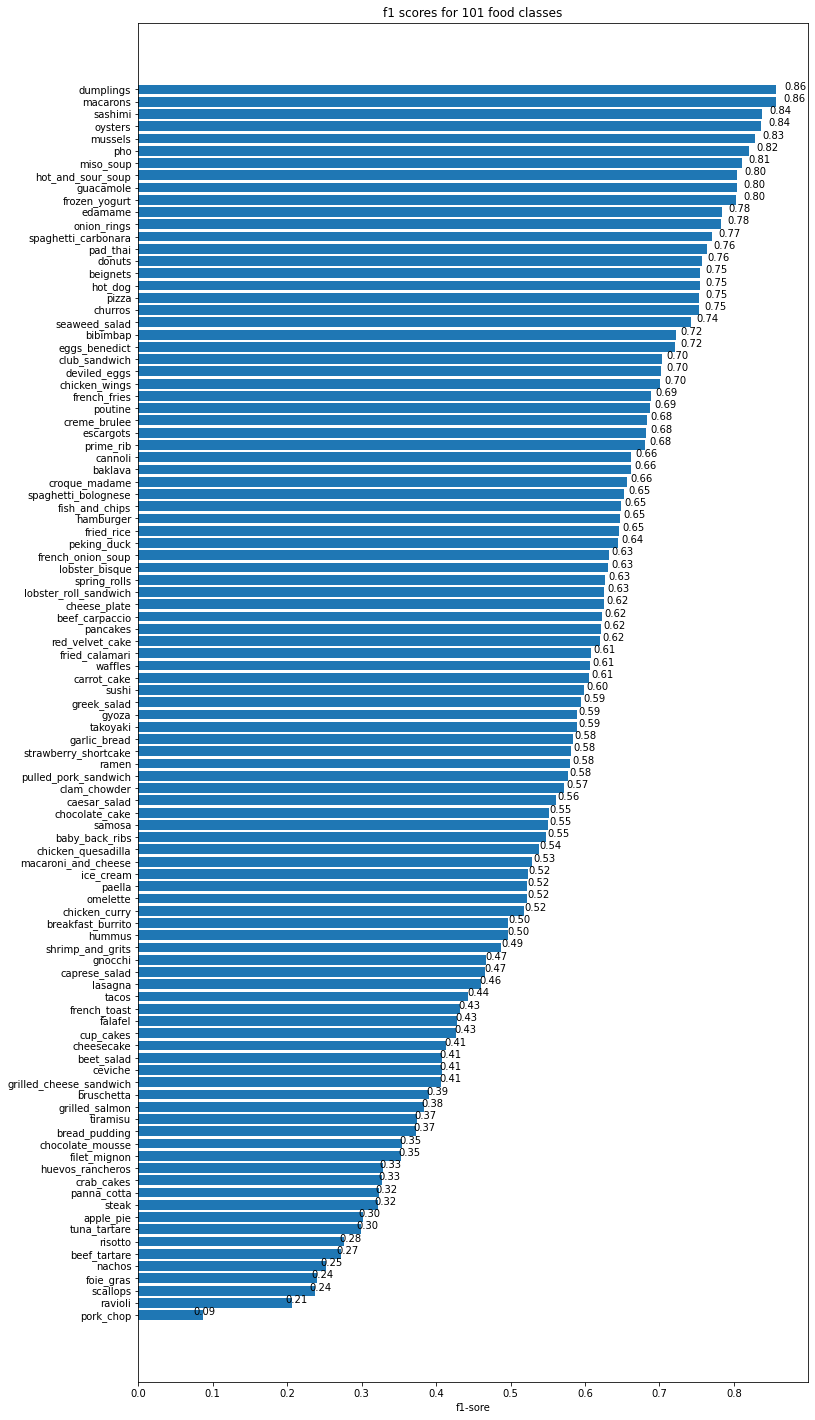

In [61]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,25))
scores = ax.barh(range(len(f1_scores)), f1_scores['f1-score'].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores['class_names'])
ax.set_xlabel('f1-sore')
ax.set_title('f1 scores for 101 food classes')
ax.invert_yaxis();

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

In [62]:
### Viz predictions on custom images and test


In [63]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img
     

In [64]:

# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

NotFoundError: ignored

<Figure size 1224x720 with 0 Axes>